# Shor's Algorithm on Tket

## Motivation – RSA Cryptosystem 

Bob wants to receive a encoded message from Alice such that only he can read it. What can he do?

1. He picks two very large (200+ bit) prime numbers $p$ and $q$
2. He sends Alice their product $N=pq$ and an encoding constant $c$ through a public channel

**Note:** $c$ must have no factors in common with $\phi(N)$, where $\phi$ is the Euler totient function. Also, $p$ and $q$ seperately must remain private. This is not a hard premise to satisfy, as factoring a ~400-bit number is unfeasible with currently available computers.

3. 

## 3. TKET Implementation

In this example we will solve the period finding problem for $a=7$ and $N=15$. We provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation. To create $U^x$, we will simply repeat the circuit $x$ times. In the next section we will discuss a general method for creating these circuits efficiently. The function `c_amod15` returns the controlled-U gate for `a`, repeated `power` times.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

#Tket port
from pytket import Circuit, OpType
from pytket.circuit import CircBox, QControlBox
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend

from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
b = AerBackend()                            # connect to the backend
print("Imports Successful")

Imports Successful


In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = Circuit(4, name="%i^%i mod 15" % (a, power))     
    for iteration in range(power):
        if a in [2,13]:
            U.SWAP(0,1)
            U.SWAP(1,2)
            U.SWAP(2,3)
        if a in [7,8]:
            U.SWAP(2,3)
            U.SWAP(1,2)
            U.SWAP(0,1)
        if a in [4, 11]:
            U.SWAP(1,3)
            U.SWAP(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.X(q)


    cU = CircBox(U)

    box = QControlBox(cU, 1)
    
    return box

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = Circuit(n, name="QFT†")
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.SWAP(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.add_gate(OpType.CU1, [-1/float(2**(j-m))], [m, j])
        qc.H(j)
    return CircBox(qc)


In [4]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

We also import the circuit for the QFT (you can read more about the QFT in the [quantum Fourier transform chapter](./quantum-fourier-transform.html#generalqft)):

In [5]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = Circuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.H(q)
    
# And auxiliary register in state |1>
qc.X(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.add_qcontrolbox(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.add_circbox(qft_dagger(n_count), range(n_count))

# Measure circuit
for i in range(n_count):
    qc.Measure(i,i)

render_circuit_jupyter(qc)  # -1 means 'do not fold' 

3372


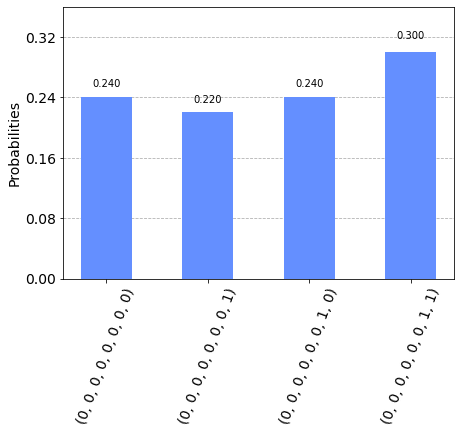

In [7]:
b = AerBackend()                            # connect to the backend
compiled = b.get_compiled_circuit(qc, optimisation_level=0)        # compile the circuit to satisfy the backend's requirements
# render_circuit_jupyter(compiled)
print(compiled.n_gates)
handle = b.process_circuit(compiled, 200)   # submit the job to run the circuit 100 times
counts = b.get_result(handle).get_counts()  # retrieve and summarise the results
plot_histogram(counts)

In [188]:
rows, measured_phases = [], []
for output in counts:

    decimal = "".join(str(ele) for ele in output)
    decimal = int(decimal[::-1],2)

    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                            Register Output           Phase
0  (0, 0, 0, 0, 0, 0, 0, 0)(bin) =   0(dec)    0/256 = 0.00
1  (0, 0, 0, 0, 0, 0, 0, 1)(bin) = 128(dec)  128/256 = 0.50
2  (0, 0, 0, 0, 0, 0, 1, 0)(bin) =  64(dec)   64/256 = 0.25
3  (0, 0, 0, 0, 0, 0, 1, 1)(bin) = 192(dec)  192/256 = 0.75


In [189]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.50      1/2            2
2   0.25      1/4            4
3   0.75      3/4            4


In [19]:
def qpe_amod15(a):
    n_count = 8
    qc = Circuit(4+n_count, n_count)
    for q in range(n_count):
        qc.H(q)     # Initialize counting qubits in state |+>
    qc.X(3+n_count) # And auxiliary register in state |1>

    for q in range(n_count): # Do controlled-U operations
        qc.add_qcontrolbox(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
    qc.add_circbox(qft_dagger(n_count), range(n_count)) # Do inverse-QFT

    for i in range(n_count):
        qc.Measure(i, i)
    

    compiled = b.get_compiled_circuit(qc, optimisation_level=0)        # compile the circuit to satisfy the backend's requirements
    handle = b.process_circuit(compiled, 200) 
    readings = b.get_result(handle).get_shots() # retrieve and summarise the results
    # print(readings[0])

    bits = ""

    for i in reversed(readings[0]):
        bits += str(i)

    # print(bits)


    print("Register Reading: " + bits)
    phase = int(bits,2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

Register Reading: 11000000
Corresponding Phase: 0.750000


0.75

In [34]:
a = 7
N=35
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 1 and 1

Attempt 2:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 3:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 1 and 5
*** Non-trivial factor found: 5 ***


## Classical Part

In [62]:
qft_dagger(3)

[SWAP q[0], q[2]; H q[0]; CU1(1.5) q[0], q[1]; CU1(1.75) q[0], q[2]; H q[1]; CU1(1.5) q[1], q[2]; H q[2]; ]

1. Pick a random number $a < N$ 
2. Find the greatest common divisor of $a$ and $N$.
> The Greatest Common Divisor (GCD) of two numbers is the largest positive integer that divides both of them. $GCD(a,b)$ can be found very fast with the Euclidean algorithm in $\mathcal{O}(log(min(a,b)))$.
3. If $GCD(a,N) \neq 1$ then we output $p=a$. Otherwise, run period finding subroutine to obtain a period $r$.
> $r$ is the smallest integer for which $f(x + r) = f(x)$, where $f(x) = a^x mod N$. The idea is that we want to find $r$ because: 

$$(a^r -1) mod N = 0.\$$

4. Then factors of $N$ should be $gcd(a^\frac{r}{2} ± 1, N)$.

> However, if $r$ is odd we need to go back to step 1 because since $a$ is also odd, then $ar$ will be odd and we will not get an integer when performing the division $\frac{ar}{2}$ on the last step.

> Also, since $(a^r-1) mod N = 0$, this imples that $a^r-1$ can be a any multiple of N, and therefore we also have to check that $a^{r/2} ≡ -1 (mod N)$. If this is the case then go back to step 1. 

## Quantum Part

> TODO: Talk about period finding subroutine

### Period finding

Traditionally, we would implement a function $f: \{0,1\}^n = [0, N-1] \longrightarrow \{0,1\}^n = [0, N-1]$ with an oracle gate $U_f$ defined as follows:
$$
f(x)=y \iff U_f \left|q \right>_{ancilla}\left|x\right>_{input} = \left|q \right>_{ancilla}\left|f(x) \oplus q \right>_{input}
$$
However, for the purposes of finding the period of a function, there is a more efficient way to encode it using only $n$ instead of $2n$ qubits:
$$
U_f\left|f(0) \right>=\left|f(1) \right> \\
U_f\left|f(1) \right>=\left|f(2) \right> \\
U_f\left|f(2) \right>=\left|f(3) \right> \\
\cdots \\
U_f\left|f(r-2) \right>=\left|f(r-1) \right> \\
U_f\left|f(r-1) \right>=\left|f(r)=f(0) \right>
$$
This defines $U_f$ for inputs $x \in f[0, N-1]$. We still have total freedom on how to define $U_f$ on the remaining inputs.

For our particular $f_a(x)=a^x \mod N$, we have:

$$
U_f\left|x\right>=\left|ax \mod N \right>
$$




[comment]: <> (Because a and N are coprime. Write it here if you havent't said it in the classical part)



However, if the function $f(x)=a^x \mod N$ is bijective from $\{0, N-1\}$ to $\{0, N-1\}$, the encoding can be performed in a simpler way using $n$ qubits instead of $n+n=2n$ qubits:
$$
U_f\left|x\right>=\left|f(x)\right>=\left|a^x \mod N\right>
$$

This gate $U_f$ has eigenvalues $e^{2\pi i \frac{s}{r}}$

In fact, 

By performing quantum phase estimation on it you can extract $r$

In [1]:
import math
import numpy as np
N=35
n=8
a=3

def f(x:int):
    return pow(a,x) % N
def is_injective(f, rng):
    values_of_f= set()
    for _input in rng:
        a=f(_input)
        values_of_f.add(a)
        
    return len(values_of_f) == len(rng)
xrange=range(64)
print(is_injective(f, xrange))

False


# Period finding (attempt 2)


Nice property of the function $f_a(x)$: it has no accidental degeneracies
Define a $n$-qubit quantum gate $U_f$ as follows:

For $x \in$ the *main cycle* $\{1, a, \cdots\}$, $U_f$ acts by cycling the $\left|x\right>$s:
$$
U_f\left|f(0) \right>=\left|f(1) \right> \\
U_f\left|f(1) \right>=\left|f(2) \right> \\
U_f\left|f(2) \right>=\left|f(3) \right> \\
\cdots \\
U_f\left|f(r-2) \right>=\left|f(r-1) \right> \\
U_f\left|f(r-1) \right>=\left|f(r)=f(0) \right>
$$

For $x \in$ all the rest, $ [0, 2^n-1]\setminus f[0,2^n-1]$, $U_f$ is defined arbitrarily.

This cyclic property of $U_f$ on $f[0, 2^n-1]$ ensures that $U_f$ has eigenvectors of the form:
$$
\left|u_0\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|a^k \mod N\right>\\
\left|u_1\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 1 /r} \left|a^k \mod N\right>\\
\left|u_2\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i\cdot 2 /r} \left|a^k \mod N\right>\\
\cdots \\
\left|u_{r-1}\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i\cdot (r-1) /r} \left|a^k \mod N\right>\\
$$
Plus other eigenvectors, which depend on the arbitrarily completed definition of $U_f$, which we don't give a shit about.
The idea is to use the Quantum Phase Estimation subroutine, which we'll talk about shortly, on one of the states of $TOBEDEFINED$ to get a phase $\Phi=\frac{s}{r}$, with $s$ a random integer.

Turning this relationship around, we have:

$$
\left|a^0 \mod N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|u_k\right>\\
\left|a^1 \mod N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 1 /r} \left|u_k\right>\\
\left|a^2 \mod N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot 2 /r} \left|u_k\right>\\
\cdots \\
\left|a^{r-1} \mod N\right>= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{2 \pi i \cdot (r-1) /r} \left|u_k\right>\\
$$

# Quantum Phase Extimation

Given a unitary $U$, with eigenvectors $U \left| \psi_{\theta} \right>=e^{2 \pi \phi}\left| \psi_{\theta} \right>$, QPE is a quantum algorithm that, when fed $\left| \psi \right>$, outputs $\phi$ as a classical output and $\left| \psi \right>$ itself as a quantum output.

Here is the circuit:

In [2]:
#INSERT HERE QPE CIRCUIT

More specifically, it outputs (to be completed) with $\left< \psi_{\phi} | \psi \right>$ probability amplitude

The time cost of the QPE algorithm is $O()$, given by the Quantum Fourier Transform in the algorithm.

Let's just focus on the first of those states in (insert ref), and apply QPE on it

$$
\left| 1 \right >= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} 1 \left|u_k\right>
$$

$\left| 1 \right >$ is an equal weight superposition of the eigenvectors, so applying QPE on it yields $\phi=\frac{s}{r}$ for a random $s$ with equal probability

Doing it a few times yields a few values of $s$:

$$
\frac{s_1}{r}, \; \frac{s_2}{r}, \; \cdots, \; \frac{s_m}{r} 
$$

From which r can be determined using a continued fractions algorithm